In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score 
from tqdm import tqdm

import joblib
import json

import warnings  
warnings.filterwarnings('ignore')

from myworkspaceutils.datasets.micro_rna import MiRNA_GSE120584_Binary
from myworkspaceutils.micro_rna.ml import MLTools

In [2]:
data_dir = f"{Path.cwd().parent.parent}/mirna_data"
mirna = MiRNA_GSE120584_Binary(data_dir)
mltools = MLTools(data_dir)
data_dir

'/home/sud/dev/mRNA/mirna_data'

In [3]:
meta_data_ad, series_mtrx_ad = mirna.load_data(cohort="discovery", label="ad")
meta_data_vad, series_mtrx_vad = mirna.load_data(cohort="discovery", label="vad")
meta_data_dlb, series_mtrx_dlb = mirna.load_data(cohort="discovery", label="dlb")

z_values = pd.read_csv(f'{data_dir}/z_values_discovery.csv')

In [4]:
series_mtrx_ad.head()

,ID_REF,GSM3403761,GSM3403762,GSM3403763,GSM3403764,GSM3403765,GSM3403766,GSM3403767,GSM3403768,GSM3403769,...,GSM3405117,GSM3405118,GSM3405119,GSM3405120,GSM3405121,GSM3405122,GSM3405123,GSM3405124,GSM3405125,GSM3405126
0,MIMAT0000062,2.307579,1.503044,1.549877,1.560269,3.179096,4.319297,0.575922,-0.180237,1.491916,...,2.694248,2.136268,1.270913,2.294335,2.608666,0.512729,1.588242,1.013859,0.777287,2.470009
1,MIMAT0000063,2.307579,2.505380,1.983125,1.560269,3.302472,4.319297,1.964171,0.697365,1.491916,...,2.694248,2.136268,2.175791,2.294335,3.004696,2.790019,2.935586,1.927544,1.789312,2.470009
2,MIMAT0000064,2.307579,1.503044,1.549877,1.560269,3.179096,4.319297,0.575922,-0.180237,1.491916,...,2.694248,2.136268,1.270913,2.294335,2.608666,0.512729,0.410802,1.013859,0.777287,2.470009
3,MIMAT0000065,2.307579,1.503044,1.549877,1.560269,3.179096,4.319297,0.575922,-0.180237,1.491916,...,2.694248,2.136268,1.270913,2.294335,2.608666,0.512729,0.410802,2.103731,0.777287,2.470009
4,MIMAT0000066,2.307579,1.503044,1.549877,2.232974,4.793470,4.319297,0.575922,-0.180237,1.491916,...,2.694248,2.136268,1.270913,2.294335,2.608666,0.512729,2.169527,1.013859,0.777287,2.470009


In [7]:
# confirm dimensions and columns 
z_values

,miRNA,ad,vad,dlb
0,MIMAT0000062,0.285971,1.791096,-1.164296
1,MIMAT0000063,-0.118869,1.941880,-0.368173
2,MIMAT0000064,-0.118954,1.691423,-0.451337
3,MIMAT0000065,0.295268,2.108311,-0.345707
4,MIMAT0000066,0.308849,2.265358,-0.657418
...,...,...,...,...
2542,MIMAT0032116,1.489672,2.838296,2.289972
2543,MIMAT0033692,1.166458,2.483795,-0.000571
2544,MIMAT0035542,-1.483081,-0.821241,0.420197
2545,MIMAT0035703,0.728334,1.524522,-0.237573


In [8]:
## Seperate z_values for each disease for future use
z_values_ad = z_values[['miRNA','ad']]
z_values_vad = z_values[['miRNA','vad']]
z_values_dlb = z_values[['miRNA','dlb']]

In [9]:
z_values_ad

,miRNA,ad
0,MIMAT0000062,0.285971
1,MIMAT0000063,-0.118869
2,MIMAT0000064,-0.118954
3,MIMAT0000065,0.295268
4,MIMAT0000066,0.308849
...,...,...
2542,MIMAT0032116,1.489672
2543,MIMAT0033692,1.166458
2544,MIMAT0035542,-1.483081
2545,MIMAT0035703,0.728334


## Running with 10-fold cross validation

### Finding best parameters using grid search for threshold and number of PCA components.

####  AD

In [11]:
y_ad_labels = meta_data_ad[['sample_id','label']].set_index('sample_id')
X_mirna_ad = series_mtrx_ad.set_index("ID_REF").T
covariates_ad = meta_data_ad[['age', 'sex', 'apoe4']]

In [9]:
y_ad_labels

,label
sample_id,
GSM3403761,1
GSM3403762,1
GSM3403763,1
GSM3403764,1
GSM3403765,1
...,...
GSM3405122,0
GSM3405123,0
GSM3405124,0


In [12]:
X_mirna_ad.head()

ID_REF,MIMAT0000062,MIMAT0000063,MIMAT0000064,MIMAT0000065,MIMAT0000066,MIMAT0000067,MIMAT0000068,MIMAT0000069,MIMAT0000070,MIMAT0000071,...,MIMAT0031892,MIMAT0031893,MIMAT0032026,MIMAT0032029,MIMAT0032110,MIMAT0032116,MIMAT0033692,MIMAT0035542,MIMAT0035703,MIMAT0035704
GSM3403761,2.307579,2.307579,2.307579,2.307579,2.307579,2.307579,2.307579,2.307579,2.307579,2.843409,...,2.307579,2.307579,2.307579,8.224806,2.307579,4.838350,5.008100,4.013143,2.307579,2.307579
GSM3403762,1.503044,2.505380,1.503044,1.503044,1.503044,1.503044,1.503044,1.503044,1.503044,3.349936,...,1.503044,1.503044,1.503044,7.921326,2.339842,4.921429,5.103016,4.232799,1.503044,1.503044
GSM3403763,1.549877,1.983125,1.549877,1.549877,1.549877,1.549877,1.549877,1.549877,1.549877,3.081569,...,1.549877,1.549877,1.549877,7.659609,2.939463,5.448523,4.882961,3.991961,1.549877,1.549877
GSM3403764,1.560269,1.560269,1.560269,1.560269,2.232974,1.560269,1.560269,1.560269,1.560269,1.890881,...,1.560269,1.560269,1.560269,7.145303,3.039567,4.421061,4.522823,3.199755,1.560269,1.560269
GSM3403765,3.179096,3.302472,3.179096,3.179096,4.793470,3.179096,3.179096,3.179096,3.179096,3.650599,...,3.179096,3.179096,3.179096,8.254947,3.179096,4.437597,4.536771,3.730172,3.179096,3.179096


In [ ]:
best_params_ad, results_df_ad = mltools.find_optimal_parameters(X_mirna_ad, y_ad_labels, covariates_ad, z_values_ad)

T: 0.30000000000000004 - M: 6:   4%|▍         | 2/50 [01:00<20:16, 25.35s/it]

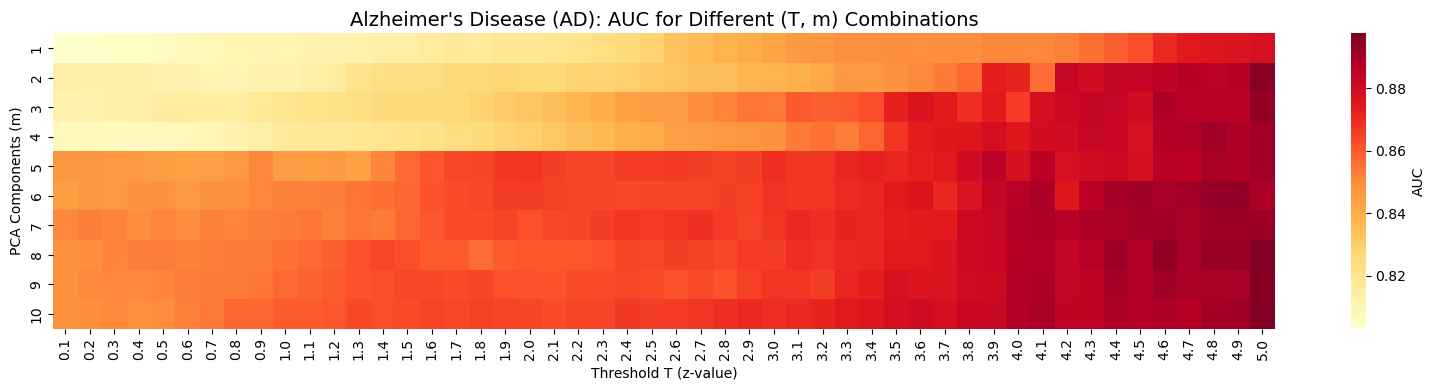

In [8]:
# Plot AD results
mltools.plot_grid_search_results(results_df_ad, "Alzheimer's Disease (AD)")

#### VaD

In [9]:
y_vad_labels = meta_data_vad[['sample_id','label']].set_index('sample_id')
X_mirna_vad = series_mtrx_vad.set_index("ID_REF").T
covariates_vad = meta_data_vad[['age', 'sex', 'apoe4']]


best_params_vad, results_df_vad = mltools.find_optimal_parameters(X_mirna_vad, y_vad_labels, covariates_vad, z_values_vad)

T: 5.0 - M: 10: 100%|██████████| 50/50 [09:03<00:00, 10.87s/it]               


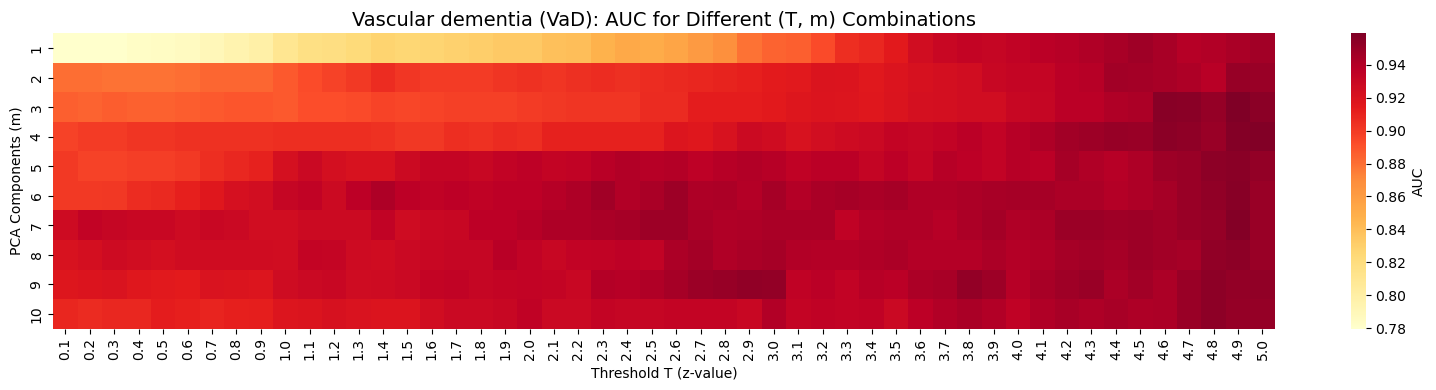

In [10]:
mltools.plot_grid_search_results(results_df_vad, "Vascular dementia (VaD)")

#### DLB

In [11]:
y_dlb_labels = meta_data_dlb[['sample_id','label']].set_index('sample_id')
X_mirna_dlb = series_mtrx_dlb.set_index("ID_REF").T
covariates_dlb = meta_data_dlb[['age', 'sex', 'apoe4']]


best_params_dlb, results_df_dlb = mltools.find_optimal_parameters(X_mirna_dlb, y_dlb_labels, covariates_dlb, z_values_dlb)

T: 5.0 - M: 10: 100%|██████████| 50/50 [07:26<00:00,  8.94s/it]               


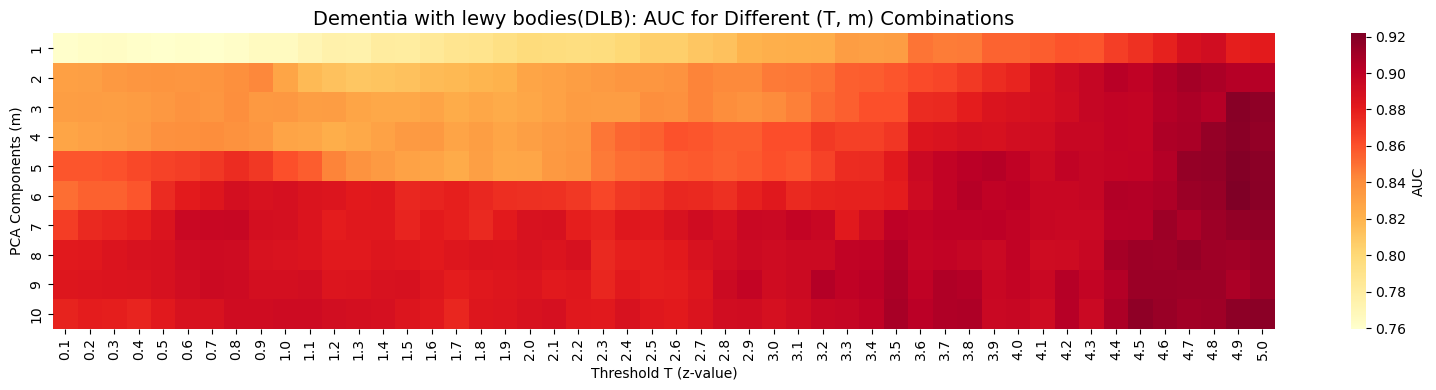

In [12]:
mltools.plot_grid_search_results(results_df_dlb, "Dementia with lewy bodies(DLB)")

### Building a final model with all discovery cohort ( NOT cross-validation )

#### AD

In [13]:

final_ad = mltools.build_and_save_final_model(
    X_train=X_mirna_ad,
    y_train=y_ad_labels,
    covariates_train=covariates_ad,
    z_values=z_values_ad,
    best_T=best_params_ad['T'],
    best_m=int(best_params_ad['m']),
    disease_name='AD'
)

Selected 26 miRNAs with |z| > 5.0
Applied PCA, kept 8 components
Model trained, training AUC: 0.913
Optimal threshold: 0.700
-Accuracy: 0.861
-Sensitivity: 0.885
-Specificity: 0.778
Final model saved: 'final_model_AD.pkl'
Selected miRNAs: 'selected_mirnas_AD.csv'
Parameters: 'model_params_AD.json'


#### Validate on validation cohort

In [19]:
meta_data_ad_v, series_mtrx_ad_v = mirna.load_data(cohort="validation", label="ad")
meta_data_vad_v, series_mtrx_vad_v = mirna.load_data(cohort="validation", label="vad")
meta_data_dlb_v, series_mtrx_dlb_v = mirna.load_data(cohort="validation", label="dlb")

In [ ]:
y_ad_labels_v = meta_data_ad_v[['sample_id','label']].set_index('sample_id')
X_mirna_ad_v = series_mtrx_ad_v.set_index("ID_REF").T
covariates_ad_v = meta_data_ad_v[['age', 'sex', 'apoe4']]

results_ad  = mltools.evaluate_on_validation(X_mirna_ad_v, covariates_ad_v, y_ad_labels_v, final_ad)
results_ad

Selected  miRNA Counts: 32 miRNAs
VALIDATION RESULTS:
- AUC:           0.858
- Accuracy:      0.708
- Sensitivity:   0.661
- Specificity:   0.875
Confusion Matrix:
- True Negatives:  126
- False Positives: 18
- False Negatives: 173
- True Positives:  337


{'auc': 0.8577205882352942,
 'accuracy': 0.7079510703363915,
 'sensitivity': 0.6607843137254902,
 'specificity': 0.875,
 'predictions': array([0.53468506, 0.72527225, 0.90525973, 0.82572977, 0.89756402,
        0.99397645, 0.87648406, 0.8513227 , 0.97691185, 0.82653089,
        0.82785415, 0.97403428, 0.99834512, 0.92044146, 0.79507224,
        0.97713416, 0.81522233, 0.98642801, 0.92083992, 0.5549858 ,
        0.92068553, 0.49591326, 0.9582888 , 0.86834641, 0.93439117,
        0.82402399, 0.75388583, 0.98329036, 0.92322344, 0.99306343,
        0.85353468, 0.77737339, 0.98095521, 0.99359723, 0.87192979,
        0.95688852, 0.56797699, 0.9746548 , 0.80304732, 0.7229413 ,
        0.95199219, 0.41233211, 0.96196395, 0.38758208, 0.83279709,
        0.61481646, 0.4633981 , 0.90080122, 0.96547012, 0.30761539,
        0.97912135, 0.9869798 , 0.271332  , 0.525129  , 0.94276357,
        0.4601767 , 0.26604978, 0.44097372, 0.81662396, 0.25168092,
        0.88509481, 0.86516725, 0.8067711 , 0.992

#### VaD

In [14]:
final_vad = mltools.build_and_save_final_model(
    X_train=X_mirna_vad,
    y_train=y_vad_labels,
    covariates_train=covariates_vad,
    z_values=z_values_vad,
    best_T=best_params_vad['T'],
    best_m=int(best_params_vad['m']),
    disease_name='VaD'
)

Selected 81 miRNAs with |z| > 4.9
Applied PCA, kept 3 components
Model trained, training AUC: 0.954
Optimal threshold: 0.141
-Accuracy: 0.874
-Sensitivity: 1.000
-Specificity: 0.833
Final model saved: 'final_model_VaD.pkl'
Selected miRNAs: 'selected_mirnas_VaD.csv'
Parameters: 'model_params_VaD.json'


In [ ]:
y_vad_labels_v = meta_data_vad_v[['sample_id','label']].set_index('sample_id')
X_mirna_vad_v = series_mtrx_vad_v.set_index("ID_REF").T
covariates_vad_v = meta_data_vad_v[['age', 'sex', 'apoe4']]

results_vad  = mltools.evaluate_on_validation(X_mirna_vad_v, covariates_vad_v, y_vad_labels_v, final_vad)
results_vad

Selected  miRNA Counts: 81 miRNAs
VALIDATION RESULTS:
- AUC:           0.798
- Accuracy:      0.751
- Sensitivity:   0.644
- Specificity:   0.785
Confusion Matrix:
- True Negatives:  113
- False Positives: 31
- False Negatives: 16
- True Positives:  29


{'auc': 0.7983024691358025,
 'accuracy': 0.7513227513227513,
 'sensitivity': 0.6444444444444445,
 'specificity': 0.7847222222222222,
 'predictions': array([3.71285722e-02, 5.35800448e-01, 1.18568308e-02, 8.45320185e-01,
        7.60676917e-01, 9.87244558e-01, 6.99956280e-01, 4.58425004e-02,
        4.30858881e-02, 5.59912118e-01, 1.81927406e-02, 1.64309225e-01,
        8.13068996e-02, 2.65233386e-02, 1.01129705e-01, 2.71760530e-01,
        2.53398076e-01, 9.08553212e-01, 8.09041862e-03, 1.78514749e-01,
        6.04760590e-02, 1.94672705e-02, 2.07492408e-01, 5.67247109e-01,
        4.02268089e-01, 1.59508135e-01, 8.97054156e-02, 6.89886149e-01,
        2.47884215e-01, 9.77844596e-01, 3.88242030e-01, 2.75364124e-02,
        2.32805875e-01, 2.45998281e-02, 2.47654135e-02, 3.32475039e-01,
        5.03904015e-01, 7.27274344e-01, 2.37117501e-01, 9.11297986e-01,
        8.52748295e-01, 7.58528798e-01, 2.46024700e-01, 1.17867710e-01,
        2.39715983e-01, 6.43182684e-03, 1.63872148e-02, 1.57

#### DLB

In [22]:
final_dlb = mltools.build_and_save_final_model(
    X_train=X_mirna_dlb,
    y_train=y_dlb_labels,
    covariates_train=covariates_dlb,
    z_values=z_values_ad,
    best_T=best_params_dlb['T'],
    best_m=int(best_params_dlb['m']),
    disease_name='DLB'
)

Selected 32 miRNAs with |z| > 4.9
Applied PCA, kept 6 components
Model trained, training AUC: 0.899
Optimal threshold: 0.321
-Accuracy: 0.834
-Sensitivity: 0.906
-Specificity: 0.792
Final model saved: 'final_model_DLB.pkl'
Selected miRNAs: 'selected_mirnas_DLB.csv'
Parameters: 'model_params_DLB.json'


In [ ]:
y_dlb_labels_v = meta_data_dlb_v[['sample_id','label']].set_index('sample_id')
X_mirna_dlb_v = series_mtrx_dlb_v.set_index("ID_REF").T
covariates_dlb_v = meta_data_dlb_v[['age', 'sex', 'apoe4']]

results_dlb  = mltools.evaluate_on_validation(X_mirna_dlb_v, covariates_dlb_v, y_dlb_labels_v, final_dlb)
results_dlb

Selected  miRNA Counts: 32 miRNAs
VALIDATION RESULTS:
- AUC:           0.821
- Accuracy:      0.759
- Sensitivity:   0.476
- Specificity:   0.924
Confusion Matrix:
- True Negatives:  133
- False Positives: 11
- False Negatives: 44
- True Positives:  40


{'auc': 0.8211805555555556,
 'accuracy': 0.7587719298245614,
 'sensitivity': 0.47619047619047616,
 'specificity': 0.9236111111111112,
 'predictions': array([0.53621538, 0.21387962, 0.64918875, 0.89566953, 0.79044357,
        0.42172107, 0.39953725, 0.32879355, 0.48356081, 0.6524541 ,
        0.83834133, 0.71670362, 0.11439304, 0.85438054, 0.68262379,
        0.25507688, 0.11140713, 0.38982943, 0.41092748, 0.08082331,
        0.3031991 , 0.20820149, 0.08195281, 0.42836921, 0.56922483,
        0.28292657, 0.11273196, 0.25291465, 0.90731387, 0.09016109,
        0.30550098, 0.13732056, 0.10118652, 0.10590961, 0.18640805,
        0.23696518, 0.10692626, 0.1659473 , 0.48738062, 0.84587663,
        0.43741985, 0.20124979, 0.11494121, 0.37014067, 0.43086819,
        0.58879295, 0.27700498, 0.65895126, 0.05280829, 0.15639359,
        0.16957298, 0.39663822, 0.66559523, 0.33265862, 0.03406047,
        0.21193112, 0.0116197 , 0.03464399, 0.30723365, 0.71613365,
        0.24817242, 0.05108514, 0.5

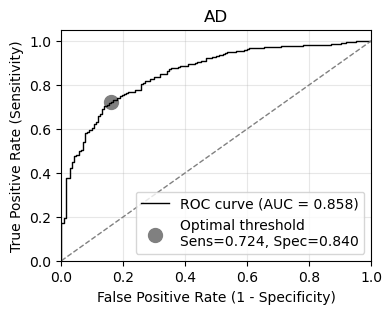

0.8577205882352942

In [ ]:
mltools.plot_roc_curve(results_ad, disease='AD')

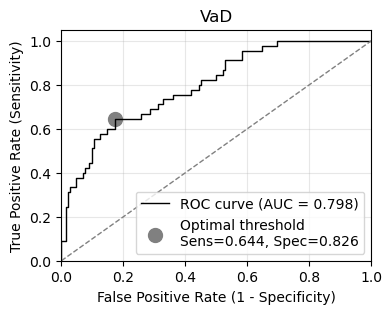

0.7983024691358025

In [ ]:
mltools.plot_roc_curve(results_vad, disease='VaD')

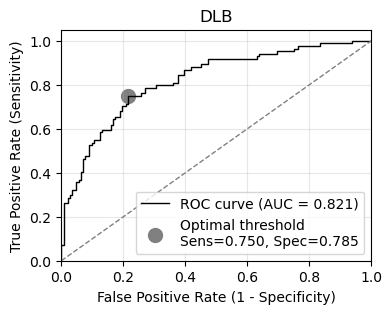

0.8211805555555556

In [ ]:
mltools.plot_roc_curve(results_dlb, disease='DLB')

In [64]:
final_ad.keys()

dict_keys(['model', 'pca', 'selected_mirnas', 'optimal_threshold', 'parameters', 'training_performance'])

In [ ]:
# Calculate performance metrics for AD

validation_metrics = mltools.calculate_performance_metrics(
    y_true=y_ad_labels_v,
    y_pred_proba=results_ad['predictions'],
    optimal_threshold=final_ad['optimal_threshold']
) 
print(f"PI cutoff: {validation_metrics['PI_cutoff']:.3f}")
print(f"Accuracy: {validation_metrics['Accuracy']:.3f}")
print(f"Sensitivity: {validation_metrics['Sensitivity']:.3f}")
print(f"Specificity: {validation_metrics['Specificity']:.3f}")



validation_metrics_vad = mltools.calculate_performance_metrics(
    y_true=y_vad_labels_v,
    y_pred_proba=results_vad['predictions'],
    optimal_threshold=final_vad['optimal_threshold']
) 
print(f"PI cutoff: {validation_metrics_vad['PI_cutoff']:.3f}")
print(f"Accuracy: {validation_metrics_vad['Accuracy']:.3f}")
print(f"Sensitivity: {validation_metrics_vad['Sensitivity']:.3f}")
print(f"Specificity: {validation_metrics_vad['Specificity']:.3f}")


validation_metrics_dlb = mltools.calculate_performance_metrics(
    y_true=y_dlb_labels_v,
    y_pred_proba=results_dlb['predictions'],
    optimal_threshold=final_dlb['optimal_threshold']
) 
print(f"PI cutoff: {validation_metrics_dlb['PI_cutoff']:.3f}")
print(f"Accuracy: {validation_metrics_dlb['Accuracy']:.3f}")
print(f"Sensitivity: {validation_metrics_dlb['Sensitivity']:.3f}")
print(f"Specificity: {validation_metrics_dlb['Specificity']:.3f}")

PI cutoff: 0.640
Accuracy: 0.708
Sensitivity: 0.661
Specificity: 0.875
PI cutoff: 0.160
Accuracy: 0.751
Sensitivity: 0.644
Specificity: 0.785
PI cutoff: 0.165
Accuracy: 0.759
Sensitivity: 0.476
Specificity: 0.924
